# Sales Analysis for Retail Grocery Data

## 1. Introduction to Retail Sales Analysis

Rohlik Group is an European e-grocery provider with  11 warehouses in Czech Republic, Germany, Austria, Hungary, and Romania.

Rohlik is committed to becoming a sustainable and efficient enterprise.

Achieving accurate sales forecasting is an important step towards this mission as it provides valuable input for key business processes (resource planning, supply chains and inventory management...) 

As such, quality forecasts can directly contribute to streamlining operation, minimizing waste, improving customer experience and thus improving future sales.

In this particular exercise, the goal is to predict **daily sales** for ~5000 SKU across 7 different warehouses using sales data from **2020 to 2024**. The warehoues are located in Hungary (Budapest), Czech (Prague, Brno), and Germany(Munich, Frankfurt)

**Time Series Analysis**

Time series data is a series of data points indexed in time order. It is distinct from cross-sectional data as cross-sectional data does not have any natural ordering.

- **Example - Time Series**: List of customer's purchases at a store captured daily.
- **Example - Cross-sectional Data**: List of current customers and their backgrounds (education level, age...).

In this particular problem, because the goal is to estimate sales for different SKUs (observations are uniquely identified not only by time but also SKU), the dataset can be more generally considered as **panel data**.

Time Series Data analysis requires contending with issues that cross-sectional data would not have, including:

- **Auto-Correlation**: Correlation between a series of data and a lagged version of itself. For example, similarity between today's sales and yesterday's sales.
- **Trend & Seasonality**:  Long term changes (persistent increase or decrease), seasonal variation at defined intervals (weekend, end of month...)



## 2. Methodology

### 2.1. Collect & Prepare Data

**Collect & Clean Data**

- Check for & Handle missing values, duplication, consistency, formatting, outliers...

- Consolidate data into one table for exploration / model building

**Extract Features** 

- Extract features from compound data (if any)

- Create lagged features to capture temporal correlations (lag by fixed period, rolling aggregates...)

- Extract time features to capture fixed seasonal trends (month, week of year...)

### 2.2. Analyze and Explore Data

- Univariate Analysis

- Mutltivariate Analysis

### 2.3. Feature Engineering

- Feature Scaling

### 2.4. Build Model

- XGBoost

### 2.5. Assess Model

-  Mean Absolute Percentage Error

## 3. Model
## 3.1. Import & Set up Data

![alt text](image.png)

In [3]:
import kagglehub
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import  STL
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import skew
import gc

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error

from skforecast.preprocessing import series_long_to_dict, exog_long_to_dict, RollingFeatures
from skforecast.recursive import ForecasterRecursiveMultiSeries
from skforecast.preprocessing import RollingFeatures

pd.set_option("display.max_columns", 100)
pd.set_option("display.max_rows", 100)

plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 8)

In [4]:
path = "Data/rohlik-sales-forecasting-challenge"
df_sales_train = pd.read_csv(f"{path}/sales_train.csv")
df_sales_test = pd.read_csv(f"{path}/sales_test.csv")
df_inventory = pd.read_csv(f"{path}/inventory.csv")
df_calendar = pd.read_csv(f"{path}/calendar.csv")

In [5]:
print("Sales Train:")
df_sales_train.info()
print()
print("Sales Test:")
df_sales_test.info()
print()
print("Inventory:")
df_inventory.info()
print()
print("Calendar:")
df_calendar.info()

Sales Train:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007419 entries, 0 to 4007418
Data columns (total 14 columns):
 #   Column           Dtype  
---  ------           -----  
 0   unique_id        int64  
 1   date             object 
 2   warehouse        object 
 3   total_orders     float64
 4   sales            float64
 5   sell_price_main  float64
 6   availability     float64
 7   type_0_discount  float64
 8   type_1_discount  float64
 9   type_2_discount  float64
 10  type_3_discount  float64
 11  type_4_discount  float64
 12  type_5_discount  float64
 13  type_6_discount  float64
dtypes: float64(11), int64(1), object(2)
memory usage: 428.0+ MB

Sales Test:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47021 entries, 0 to 47020
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   unique_id        47021 non-null  int64  
 1   date             47021 non-null  object 
 2   warehouse        4

## 3.2. Clean Data
### 3.2.1. Basic Checks

In [6]:
df_sales_train.sample(5)

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount
120488,1556,2023-02-05,Prague_1,9625.0,237.15,54.45,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
399346,4732,2022-02-06,Prague_1,9541.0,62.99,130.84,0.67,0.0,0.0,0.0,0.0,0.0,0.0,0.05904
1068866,777,2023-12-05,Prague_3,5326.0,25.23,50.52,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
3001433,1806,2022-10-03,Budapest_1,5571.0,57.38,849.08,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00000
2512921,1553,2022-12-18,Prague_1,10633.0,56.06,30.31,1.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00000


In [7]:
print("Sales Train Data")
# Change data type
df_sales_train["date"] = pd.to_datetime(df_sales_train["date"])

# Check for Duplicates
print("Duplicated Rows - Key: Date, Unique ID:")
print(df_sales_train.duplicated(["unique_id","date"]).sum())
print()
# Check for Null Values
print("Null Counts by Column:")
print(df_sales_train.isnull().sum())
print()
print("Null Counts by Warehouse and Product:")
print(df_sales_train[df_sales_train.isnull().any(axis=1)]\
    .groupby(["warehouse","unique_id"])["warehouse"].value_counts())
# Drop Rows containing Nulls because instances are few
df_sales_train.dropna(how="any",inplace=True)

Sales Train Data
Duplicated Rows - Key: Date, Unique ID:
0

Null Counts by Column:
unique_id           0
date                0
warehouse           0
total_orders       52
sales              52
sell_price_main     0
availability        0
type_0_discount     0
type_1_discount     0
type_2_discount     0
type_3_discount     0
type_4_discount     0
type_5_discount     0
type_6_discount     0
dtype: int64

Null Counts by Warehouse and Product:
warehouse    unique_id
Frankfurt_1  612          2
             794          2
             1237         2
Munich_1     725          2
             885          4
             1689         2
             1776         1
             2148         7
             2424         8
             2809         4
             3178         7
             3778         7
             5152         4
Name: count, dtype: int64


In [8]:
print("Calendar Data")

# Change data type
df_calendar["date"] = pd.to_datetime(df_calendar["date"])

# Check for Duplicates
print("Duplicated Rows - Key: Date, Warehouse:")
print(df_calendar.duplicated(["date","warehouse"]).sum())
print()
# Check for Null Values
print("Null Counts by Column - Null Expected for Holiday Name:")
print(df_calendar.isnull().sum())
df_calendar.sort_values(["date","warehouse"]).head()

Calendar Data
Duplicated Rows - Key: Date, Warehouse:
0

Null Counts by Column - Null Expected for Holiday Name:
date                          0
holiday_name              22086
holiday                       0
shops_closed                  0
winter_school_holidays        0
school_holidays               0
warehouse                     0
dtype: int64


,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,warehouse
17698,2016-01-01,New Years Day,1,1,0,0,Brno_1
9914,2016-01-01,New Years Day,1,1,0,0,Budapest_1
9911,2016-01-01,New Years Day,1,1,0,0,Frankfurt_1
22413,2016-01-01,New Years Day,1,1,0,0,Munich_1
22407,2016-01-01,New Years Day,1,1,0,0,Prague_1


In [9]:
print("Inventory Data")
# Check for Duplicates
print("Duplicated Rows - Key: Unique ID:")
print(df_inventory.duplicated(["unique_id"]).sum())
print()
# Check for Null Values
print("Null Counts by Column:")
print(df_inventory.isnull().sum())
df_inventory.head()

Inventory Data
Duplicated Rows - Key: Unique ID:
0

Null Counts by Column:
unique_id              0
product_unique_id      0
name                   0
L1_category_name_en    0
L2_category_name_en    0
L3_category_name_en    0
L4_category_name_en    0
warehouse              0
dtype: int64


,unique_id,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,warehouse
0,5255,2583,Pastry_196,Bakery,Bakery_L2_14,Bakery_L3_26,Bakery_L4_1,Prague_3
1,4948,2426,Herb_19,Fruit and vegetable,Fruit and vegetable_L2_30,Fruit and vegetable_L3_86,Fruit and vegetable_L4_1,Prague_3
2,2146,1079,Beet_2,Fruit and vegetable,Fruit and vegetable_L2_3,Fruit and vegetable_L3_65,Fruit and vegetable_L4_34,Prague_1
3,501,260,Chicken_13,Meat and fish,Meat and fish_L2_13,Meat and fish_L3_27,Meat and fish_L4_5,Prague_1
4,4461,2197,Chicory_1,Fruit and vegetable,Fruit and vegetable_L2_17,Fruit and vegetable_L3_33,Fruit and vegetable_L4_1,Frankfurt_1


### 3.2.2. Merge Dataframes

In [10]:
def merge_inventory_calendar(df):
    df_merged = df.merge(right=df_inventory.drop(["warehouse"],axis=1),on=["unique_id"],how="left")\
                            .merge(right=df_calendar, on=["warehouse","date"], how="left")
    return df_merged
df_enriched = merge_inventory_calendar(df_sales_train)
df_enriched.head()

,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays
0,4845,2024-03-10,Budapest_1,6436.0,16.34,646.26,1.00,0.00000,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
1,4845,2021-05-25,Budapest_1,4663.0,12.63,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
2,4845,2021-12-20,Budapest_1,6507.0,34.55,455.96,1.00,0.00000,0.0,0.0,0.0,0.15025,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
3,4845,2023-04-29,Budapest_1,5463.0,34.52,646.26,0.96,0.20024,0.0,0.0,0.0,0.15312,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0
4,4845,2022-04-01,Budapest_1,5997.0,35.92,486.41,1.00,0.00000,0.0,0.0,0.0,0.15649,0.0,0.0,2375,Croissant_35,Bakery,Bakery_L2_18,Bakery_L3_83,Bakery_L4_1,NaN,0,0,0,0


In [11]:
print("Check Counts of Merged Dataframe:")
print(f"Sales Train:{df_sales_train.shape}")
print(f"Merged Train:{df_enriched.shape}")
print()
print("Inspect Merged Dataframe")
df_enriched.info()
print()
print("Check Null Counts by Column - Null Expected for Holiday Name:")
print(df_enriched.isnull().sum())

Check Counts of Merged Dataframe:
Sales Train:(4007367, 14)
Merged Train:(4007367, 25)

Inspect Merged Dataframe
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4007367 entries, 0 to 4007366
Data columns (total 25 columns):
 #   Column                  Dtype         
---  ------                  -----         
 0   unique_id               int64         
 1   date                    datetime64[ns]
 2   warehouse               object        
 3   total_orders            float64       
 4   sales                   float64       
 5   sell_price_main         float64       
 6   availability            float64       
 7   type_0_discount         float64       
 8   type_1_discount         float64       
 9   type_2_discount         float64       
 10  type_3_discount         float64       
 11  type_4_discount         float64       
 12  type_5_discount         float64       
 13  type_6_discount         float64       
 14  product_unique_id       int64         
 15  name                 

## 3.2.3 Extract Features

In [12]:
def extract_date_features(df):

    df["date_year"] = df["date"].dt.year
    df["date_month"] = df["date"].dt.month
    df["date_dayofmonth"] = df["date"].dt.isocalendar().day

    df["date_quarter"] = df["date"].dt.quarter

    df["date_weekofyear"] = df["date"].dt.isocalendar().week
    df["date_dayofyear"] = df["date"].dt.dayofyear
    df["date_dayofweek"] = df["date"].dt.dayofweek

    df["date_is_weekend"] = df["date_dayofweek"] >= 5

extract_date_features(df_enriched)
df_enriched[df_enriched.columns[df_enriched.columns.str.startswith("date")]].head()

,date,date_year,date_month,date_dayofmonth,date_quarter,date_weekofyear,date_dayofyear,date_dayofweek,date_is_weekend
0,2024-03-10,2024,3,7,1,10,70,6,True
1,2021-05-25,2021,5,2,2,21,145,1,False
2,2021-12-20,2021,12,1,4,51,354,0,False
3,2023-04-29,2023,4,6,2,17,119,5,True
4,2022-04-01,2022,4,5,2,13,91,4,False


In [13]:
def extract_city_feature(df):
    df["warehouse_city"] = df["warehouse"].str.split("_",expand=True)[0]
extract_city_feature(df_enriched)
df_enriched[["warehouse","warehouse_city"]].head()

,warehouse,warehouse_city
0,Budapest_1,Budapest
1,Budapest_1,Budapest
2,Budapest_1,Budapest
3,Budapest_1,Budapest
4,Budapest_1,Budapest


In [14]:
# Create features after merging and EDA
df_enriched = df_enriched.sort_values(["unique_id", "date"]).reset_index(drop=True)

for col in ["sales", "total_orders", "sell_price_main", "availability"]:
    df_enriched[f"{col}_lag_1"] = df_enriched.groupby("unique_id")[col].shift(1)

for n_lag in [7, 30]:
    df_enriched[f"sales_lag_{n_lag}"] = df_enriched.groupby("unique_id")["sales"].shift(n_lag)

    df_enriched[f"sales_rolling_mean_{n_lag}"] = df_enriched.groupby("unique_id")["sales"].shift(1).rolling(n_lag).mean()
    df_enriched[f"sales_rolling_max_{n_lag}"] = df_enriched.groupby("unique_id")["sales"].shift(1).rolling(n_lag).max()
    df_enriched[f"sales_rolling_min_{n_lag}"] = df_enriched.groupby("unique_id")["sales"].shift(1).rolling(n_lag).min()
    df_enriched[f"sales_rolling_std_{n_lag}"] = df_enriched.groupby("unique_id")["sales"].shift(1).rolling(n_lag).std()


df_enriched.dropna(subset=df_enriched.columns[df_enriched.columns.str.startswith("sales_")],inplace=True)

In [17]:
# Sort Values & Fill N/A for column name   
df_enriched = df_enriched.sort_values(["unique_id","date"]).fillna({"holiday_name":"None"})

# Check Data Shape
print("Shape:", df_enriched.shape)
print()
# Check for Null Values
print("Null Counts:")
print(df_enriched.isnull().sum().sum())

df_enriched.head()

Shape: (3847908, 48)

Null Counts:
0


,unique_id,date,warehouse,total_orders,sales,sell_price_main,availability,type_0_discount,type_1_discount,type_2_discount,type_3_discount,type_4_discount,type_5_discount,type_6_discount,product_unique_id,name,L1_category_name_en,L2_category_name_en,L3_category_name_en,L4_category_name_en,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,date_year,date_month,date_dayofmonth,date_quarter,date_weekofyear,date_dayofyear,date_dayofweek,date_is_weekend,warehouse_city,sales_lag_1,total_orders_lag_1,sell_price_main_lag_1,availability_lag_1,sales_lag_7,sales_rolling_mean_7,sales_rolling_max_7,sales_rolling_min_7,sales_rolling_std_7,sales_lag_30,sales_rolling_mean_30,sales_rolling_max_30,sales_rolling_min_30,sales_rolling_std_30
30,0,2023-07-24,Budapest_1,5661.0,376.42,853.2,1.0,0.30025,0.0,0.0,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,None,0,0,0,0,2023,7,1,3,30,205,0,False,Budapest,376.81,5262.0,853.2,1.0,89.18,239.740000,417.57,24.35,165.666560,3.97,214.279667,607.79,3.97,185.051625
31,0,2023-07-25,Budapest_1,5637.0,403.69,853.2,0.9,0.30025,0.0,0.0,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,None,0,0,0,0,2023,7,2,3,30,206,1,False,Budapest,376.42,5661.0,853.2,1.0,85.95,280.774286,417.57,24.35,157.532471,73.36,226.694667,607.79,14.03,182.937183
32,0,2023-07-26,Budapest_1,5485.0,98.97,853.2,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,None,0,0,0,0,2023,7,3,3,30,207,2,False,Budapest,403.69,5637.0,853.2,0.9,359.02,326.165714,417.57,24.35,136.398909,558.09,237.705667,607.79,14.03,183.330580
33,0,2023-07-27,Budapest_1,5490.0,115.35,853.2,1.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,None,0,0,0,0,2023,7,4,3,30,208,3,False,Budapest,98.97,5485.0,853.2,1.0,417.57,289.015714,417.57,24.35,159.428984,14.03,222.401667,607.79,14.03,174.619590
34,0,2023-07-28,Budapest_1,5621.0,66.71,853.2,0.4,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0,Plum_0,Fruit and vegetable,Fruit and vegetable_L2_0,Fruit and vegetable_L3_0,Fruit and vegetable_L4_0,None,0,0,0,0,2023,7,5,3,30,209,4,False,Budapest,115.35,5490.0,853.2,1.0,24.35,245.841429,403.69,24.35,159.734701,558.53,225.779000,607.79,24.35,171.400635


In [18]:
gc.collect()

76

## 3.3 Exploratory Data Analysis

**Warehouse Level**

At the warehouse level, there is a general upwards trend over time.

There are also visible strong seasonal trends such as dips in sales around the months of July and August, as well as towards year end around November.

Looking at seasonal decomposition, fluctuation in sales cycles are higher in the first half of the year as opposed to the latter half.

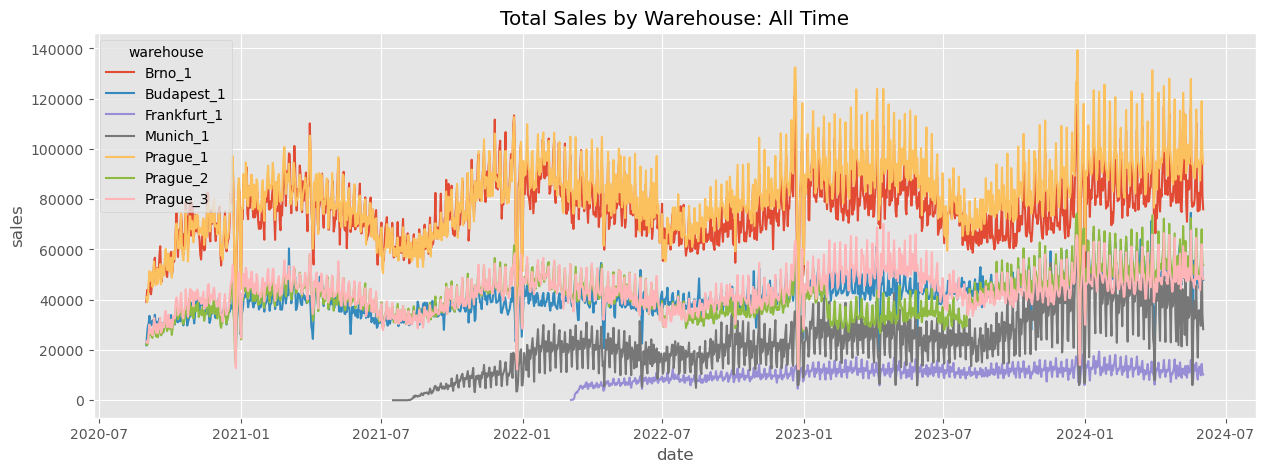

In [21]:
# Group By Warehouse for Simpler Visualization
df_enriched_sales_by_warehouse = df_enriched.groupby(["warehouse","date"])["sales"].sum().reset_index()

fig,ax = plt.subplots(figsize=(15,5))
sns.lineplot(df_enriched_sales_by_warehouse,
             x = "date", y = "sales", hue="warehouse", ax=ax)
ax.set_title("Total Sales by Warehouse: All Time")
plt.show()

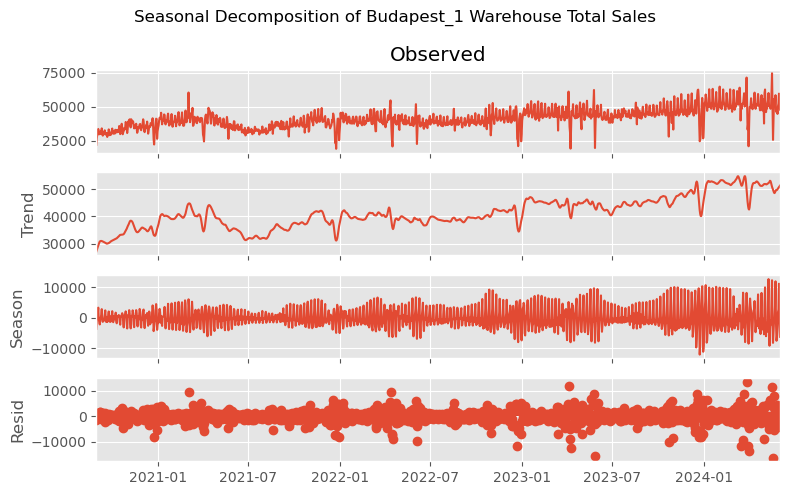

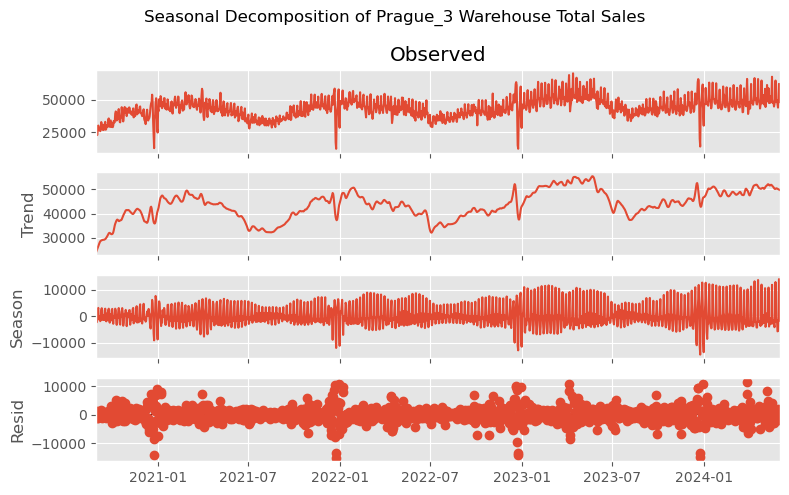

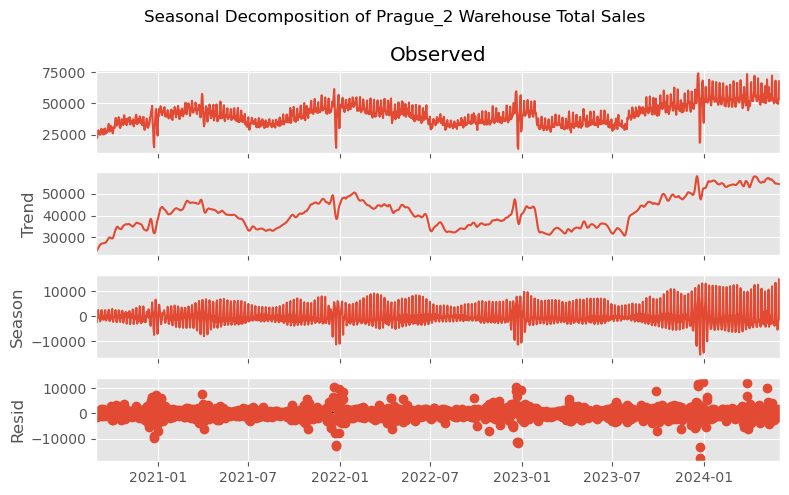

In [34]:
warehouse_li = df_enriched["warehouse"].unique()

with plt.rc_context():
    plt.rc("figure", figsize=(8,5))
    for warehouse in np.random.choice(warehouse_li,3):
        res_sdec_sales_by_warehoure = STL(
            df_enriched_sales_by_warehouse[df_enriched_sales_by_warehouse["warehouse"] == warehouse][["date","sales"]].set_index("date").asfreq(freq='D', fill_value = 0.0)).fit()
        res_sdec_sales_by_warehoure.plot()
        plt.suptitle(f'Seasonal Decomposition of {warehouse} Warehouse Total Sales')
        plt.tight_layout()
plt.show()

Holiday effects are also in play.
- For example, there are sizeable sales peaks leading up to major holidays like New Years or Christmas, then dips closer to the date as consumers finish stocking up.
- Regional Holidays i.e. national unity day... may also have effects on sales in the particular region, but are harder to detect by eye in aggregate graphs.

In terms of weekly cycles, sales generally is highest on Friday, sees a slight bump from Saturday to Sunday, then fluctuates for the remaining weekdays.
- The model should therefore also account for these weekly cycles

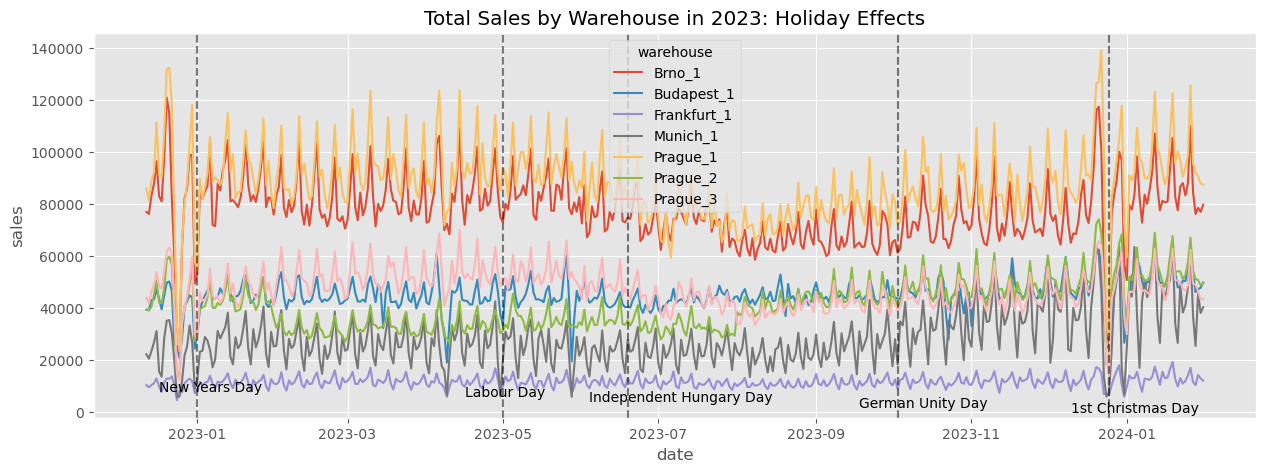

In [29]:
df_enriched_sales_by_warehouse["date_is_weekend"] = df_enriched_sales_by_warehouse['date'].dt.weekday >= 5

sample_holidays = df_calendar[(pd.to_datetime(df_calendar["date"]).dt.year == 2023) 
            & (df_calendar["holiday_name"].isin(["New Years Day","Labour Day","German Unity Day","Independent Hungary Day","1st Christmas Day"]))]\
    .groupby("holiday_name")["date"].min().reset_index()


fig, ax = plt.subplots(figsize = (15, 5))


sns.lineplot(df_enriched_sales_by_warehouse[(df_enriched_sales_by_warehouse["date"] >= dt.datetime(2022,12,12))
                                             & (df_enriched_sales_by_warehouse["date"] <= dt.datetime(2024,1,31) ) ],
             x = "date", y = "sales", hue="warehouse", ax=ax)

for idx, holiday_name, date in sample_holidays.itertuples():
    ax.axvline(x=date, color="black", linestyle ="--", alpha=0.5)
    ax.annotate(text = holiday_name, xy = (date -  dt.timedelta(days=15), idx*2000))

ax.set_title("Total Sales by Warehouse in 2023: Holiday Effects")

plt.show()

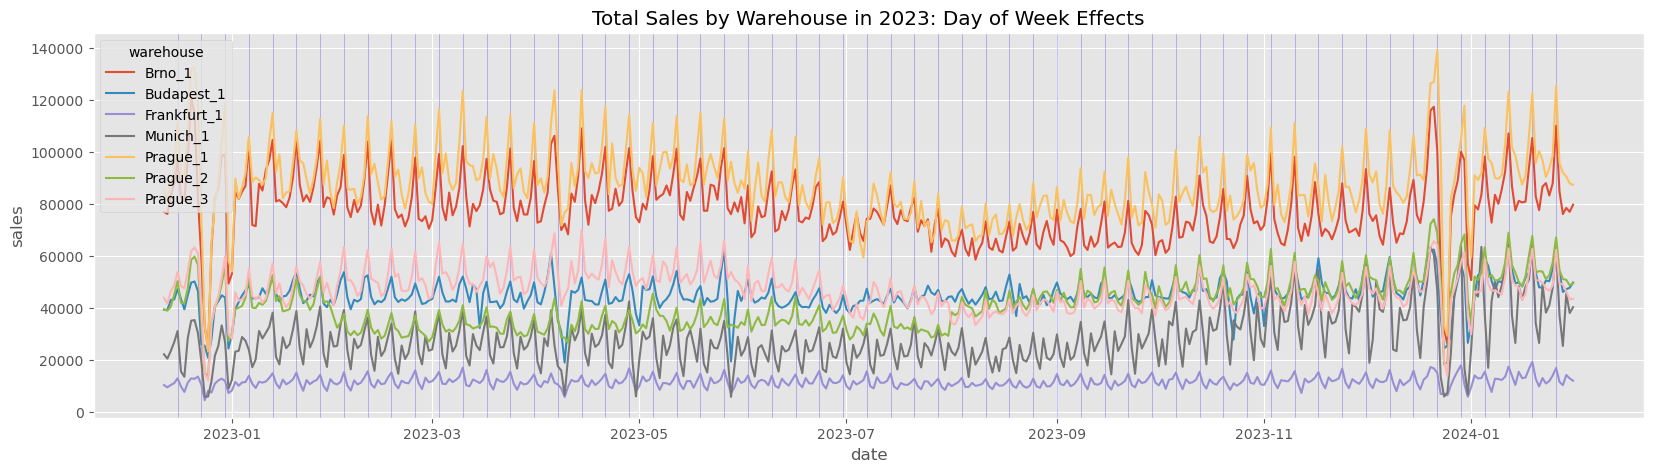

In [30]:
fig, ax = plt.subplots(figsize = (20, 5))


for date in df_enriched_sales_by_warehouse[(df_enriched_sales_by_warehouse["date"] >= dt.datetime(2022,12,12))
                                             & (df_enriched_sales_by_warehouse["date"] <= dt.datetime(2024,1,31) ) 
                                             & (df_enriched_sales_by_warehouse["date"].dt.dayofweek == 4)]["date"]:
    ax.axvline(x=date, color="blue", alpha=0.05, linewidth = 0.5)

sns.lineplot(df_enriched_sales_by_warehouse[(df_enriched_sales_by_warehouse["date"] >= dt.datetime(2022,12,12))
                                             & (df_enriched_sales_by_warehouse["date"] <= dt.datetime(2024,1,31) ) ],
             x = "date", y = "sales", hue="warehouse", ax=ax)


ax.set_title("Total Sales by Warehouse in 2023: Day of Week Effects")

plt.show()

For all warehouses, there is strong autocorrelation up to 80 lags.

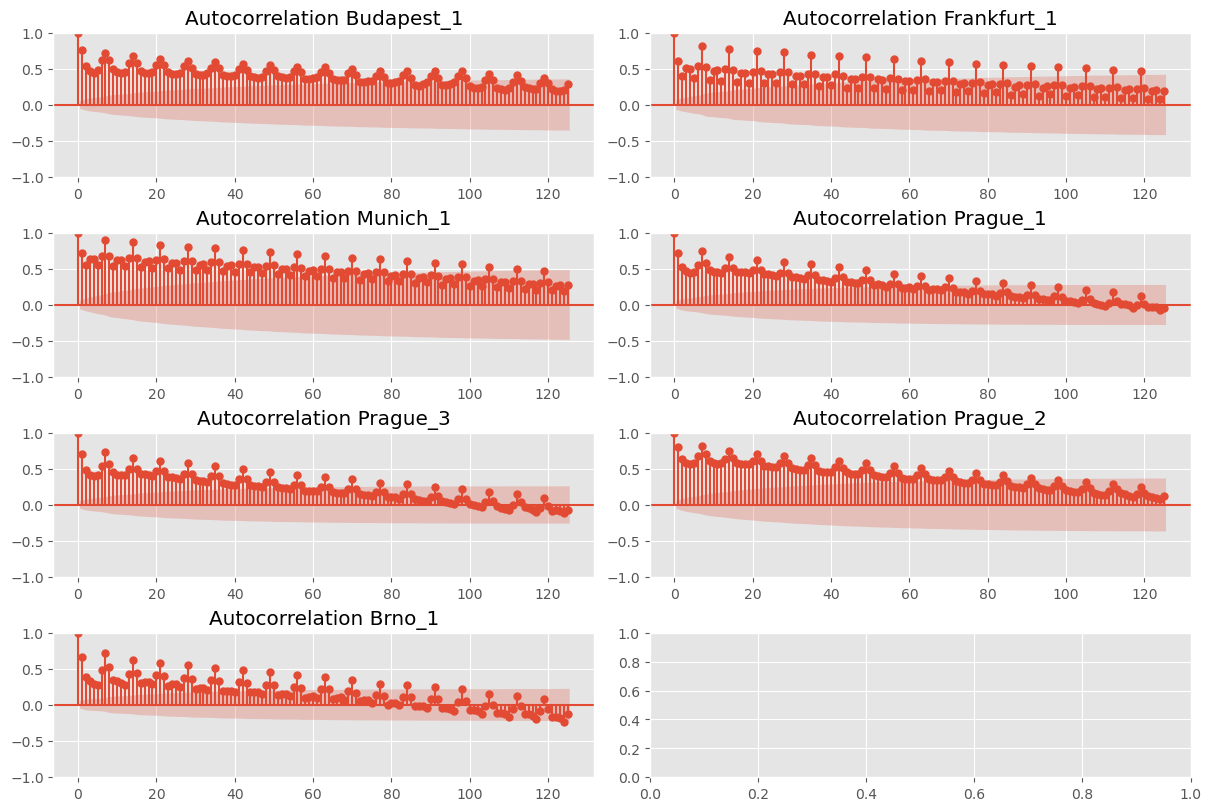

In [37]:
fig, axes = plt.subplots(ncols=2, nrows= int(round(len(warehouse_li)/2)), constrained_layout = True)
axes = axes.ravel()
for i  in range(len(warehouse_li)):
    plot_acf(df_enriched_sales_by_warehouse[df_enriched_sales_by_warehouse["warehouse"] == warehouse_li[i]][["date","sales"]].set_index("date").asfreq(freq='D', fill_value=0.0)
             , lags= 125
             , title = f"Autocorrelation {warehouse_li[i]}"
             , ax=axes[i])
plt.show()

**Product Level**

It is difficult to analyze product by product due to the volume of data.

By looking at a small random sample, as can be intiuited, we can see different products have sales trend.

Producs have different seasonal trends. Staple food products may have consistent sales, whereas seasonal product, or holiday specific products would have large gaps of no sales then peaks during specific times of year. 

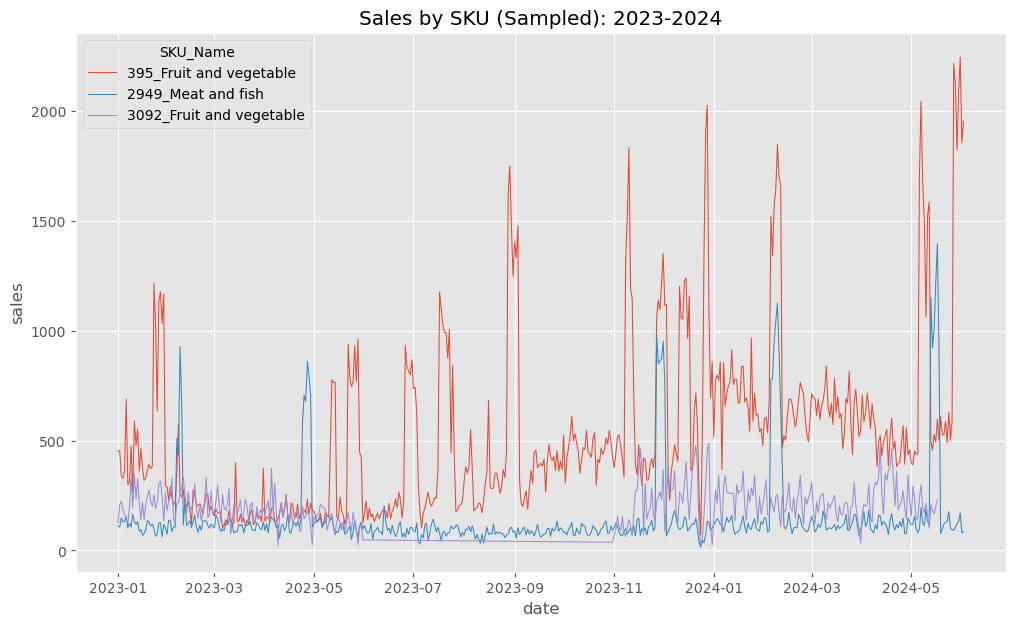

In [38]:
# Sample SKU
random_sku_sample = df_inventory["unique_id"].sample(n = 3, random_state = 35).to_list()
df_enriched_sales_by_sku_sample = df_enriched[df_enriched["unique_id"].isin(random_sku_sample)][["unique_id","warehouse","date","sales","L1_category_name_en"]].reset_index()
df_enriched_sales_by_sku_sample["SKU_Name"] = df_enriched_sales_by_sku_sample.apply(lambda row: str(row["unique_id"]) +"_" +  row["L1_category_name_en"] , axis=1)

# Plot
fig, ax = plt.subplots(figsize=(12,7))
sns.lineplot(df_enriched_sales_by_sku_sample[(df_enriched_sales_by_sku_sample["date"].dt.year == 2023)|(df_enriched_sales_by_sku_sample["date"].dt.year == 2024)],
             x = "date", y = "sales", hue="SKU_Name", 
             markers=True,
             linewidth = 0.75, markersize=5,
             ax=ax)
ax.set_title("Sales by SKU (Sampled): 2023-2024")
plt.show()

**Value Distribution**

Because we are only using Gradient Boosting, we'll only examamine the target feature **Sales** for skew and see if we need to scale it.

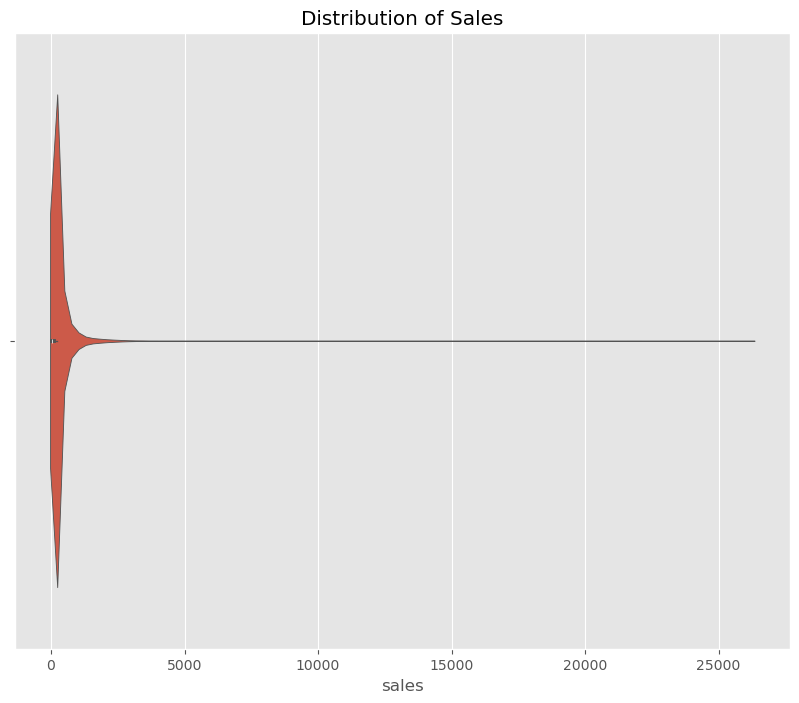

In [42]:
fig, ax = plt.subplots(figsize=(10,8))
sns.violinplot(df_enriched, x="sales", ax = ax)
ax.set_title("Distribution of Sales")
plt.show()

## 3.4. Gradient Boosting Model using sklearn

### 3.4.1. Full-Feature Model: Original Scale

#### Build Model

In [ ]:
# Define features and target
features_to_exclude = ["date","sales","total_orders", "sell_price_main", "availability"]
features = [i for i in df_enriched.columns.to_list() if i not in features_to_exclude]
target = "sales"

print("Feature:", features)
print("Target:", target)

cat_cols = ['unique_id', 'warehouse', 'warehouse_city',
            'product_unique_id', 'name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en',
            'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays','date_is_weekend',
            'holiday_name', 'date_month', 'date_dayofmonth', 'date_quarter', 'date_weekofyear', 'date_dayofyear', 'date_dayofweek']
num_cols = [col for col in features if col not in cat_cols]

# Change Datatype for Categorical Columns for Easier Processing
df_enriched[cat_cols] = df_enriched[cat_cols].astype(dtype="object")


Feature: ['unique_id', 'warehouse', 'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount', 'product_unique_id', 'name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'date_year', 'date_month', 'date_dayofmonth', 'date_quarter', 'date_weekofyear', 'date_dayofyear', 'date_dayofweek', 'date_is_weekend', 'warehouse_city', 'sales_lag_1', 'total_orders_lag_1', 'sell_price_main_lag_1', 'availability_lag_1', 'sales_lag_7', 'sales_rolling_mean_7', 'sales_rolling_max_7', 'sales_rolling_min_7', 'sales_rolling_std_7', 'sales_lag_30', 'sales_rolling_mean_30', 'sales_rolling_max_30', 'sales_rolling_min_30', 'sales_rolling_std_30']
Target: sales


In [98]:
# Train/Test split
df_enriched["date"] = pd.to_datetime(df_enriched["date"])
df_train = df_enriched[(df_enriched["date"] >= "2021-01-01") & (df_enriched["date"] < "2024-01-01")]
df_test = df_enriched[df_enriched["date"] >= "2024-01-01"]

X_train = df_train[features]
y_train = df_train[target]
X_test = df_test[features]
y_test = df_test[target]

print("Train Size:", X_train.shape)
print("Test Size:", X_test.shape)

Train Size: (3090777, 43)
Test Size: (524997, 43)


In [72]:
# Build Pipeline
preprocessor = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols)
])

model = Pipeline([
    ("pre", preprocessor),
    ("xgb", GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42))
])

In [73]:
# Train model
model.fit(X_train, y_train)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['type_0_discount',
                                                   'type_1_discount',
                                                   'type_2_discount',
                                                   'type_3_discount',
                                                   'type_4_discount',
                                                   'type_5_discount',
                                                   'type_6_discount',
                                                   'date_year', 'sales_lag_1',
                                                   'total_orders_lag_1',
                                                   'sell_price_main_lag_1',
                                                   'availability_lag_1',
                                                   'sales_lag_7',
                                                   'sales_rolling_mean_7',
                                                   'sales_rolling_max...
                                                   'L1_category_name_en',
                                                   'L2_category_name_en',
                                                   'L3_category_name_en',
                                                   'L4_category_name_en',
                                                   'holiday', 'shops_closed',
                                                   'winter_school_holidays',
                                                   'school_holidays',
                                                   'date_is_weekend',
                                                   'holiday_name', 'date_month',
                                                   'date_dayofmonth',
                                                   'date_quarter',
                                                   'date_weekofyear',
                                                   'date_dayofyear',
                                                   'date_dayofweek'])])),
                ('xgb',
                 GradientBoostingRegressor(max_depth=5, random_state=42))])

#### Predict & Evaluate

In [74]:
# Predict and evaluate
y_train_pred = model.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_train_pred)

y_test_pred = model.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_test_pred)

performance_df = pd.DataFrame(data={
    "Set": ["Train", "Train", "Train", "Test", "Test", "Test"],
    "Estimator": ["GradientBoosting", "Target Lag 1", "7-day Rolling Average", "GradientBoosting", "Target Lag 1", "7-day Rolling Average"],
    "RMSE": [rmse_train, root_mean_squared_error(y_train, df_train["sales_lag_1"].fillna(0)), root_mean_squared_error(y_train, df_train["sales_rolling_mean_7"]),
             rmse_test, root_mean_squared_error(y_test, df_test["sales_lag_1"]), root_mean_squared_error(y_test, df_test["sales_rolling_mean_7"])]
})

performance_df

,Set,Estimator,RMSE
0,Train,GradientBoosting,57.883
1,Train,Target Lag 1,91.167
2,Train,7-day Rolling Average,92.087
3,Test,GradientBoosting,71.094
4,Test,Target Lag 1,98.627
5,Test,7-day Rolling Average,101.164


In [84]:
print("RMSE Increase between Train & Test:")
print(f"{((rmse_test - rmse_train) * 100.0 / rmse_train): .3f}%")

RMSE Increase between Train & Test:
 22.823%


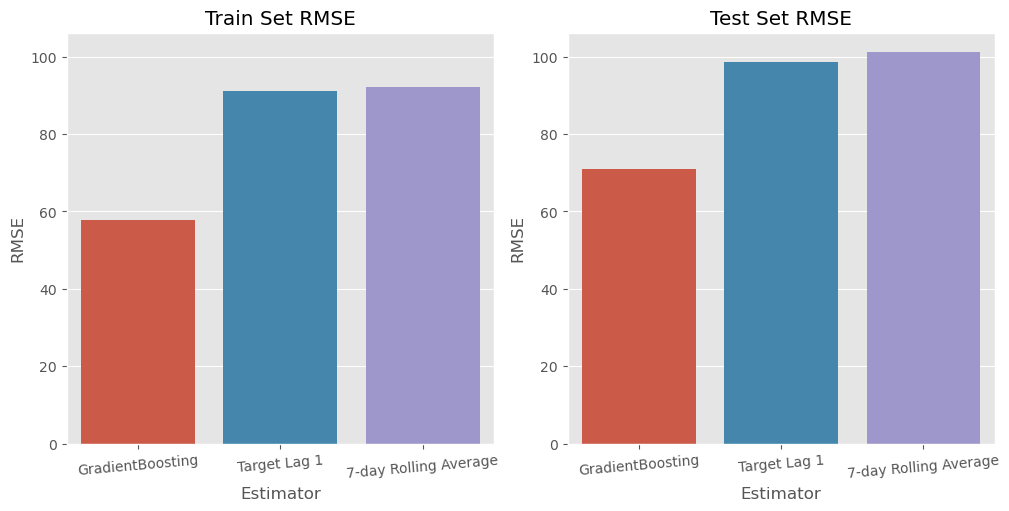

In [75]:
fig, axes = plt.subplots(nrows=1, ncols=2, 
                         layout ="constrained",
                         figsize=(10,5))

sns.barplot(performance_df[performance_df["Set"]=="Train"], 
                    x = "Estimator", y = "RMSE", 
                    hue = "Estimator",
                    ax=axes[0])
axes[0].xaxis.set_tick_params(labelrotation=5)
axes[0].set_title(f"Train Set RMSE")

sns.barplot(performance_df[performance_df["Set"]=="Test"], 
                    x = "Estimator", y = "RMSE",
                    hue = "Estimator",
                    ax=axes[1])
axes[1].xaxis.set_tick_params(labelrotation=5)
axes[1].set_title(f"Test Set RMSE")

if axes[0].get_ylim() > axes[1].get_ylim():
    axes[1].sharey(axes[0])
else:
    axes[0].sharey(axes[1])
    
    
plt.show()

In [76]:
df_train_expanded = df_train.copy()
df_train_expanded["sales_pred"] = y_train_pred

train_abs_perc_error = abs(df_train_expanded["sales_pred"] - df_train_expanded["sales"])*100.0 / df_train_expanded["sales"]
test_abs_perc_error = abs(y_test_pred - y_test)*100 / y_test

with pd.option_context('display.float_format', lambda x: f'{x:,.3f}'):
    display(pd.merge( train_abs_perc_error.rename("Train").describe(percentiles=[0.25, 0.5, 0.75, 0.9]), 
         test_abs_perc_error.rename("Test").describe(percentiles=[0.25, 0.5, 0.75, 0.9]), left_index= True, right_index=True))


,Train,Test
count,"3,090,777.000","524,997.000"
mean,inf,inf
std,NaN,NaN
min,0.000,0.000
25%,9.416,9.145
50%,20.825,19.983
75%,40.592,37.864
90%,88.318,73.881
max,inf,inf


#### Feature Importance & Feature Selection

Feature Importances:


count   10785.000
mean        0.000
std         0.007
min         0.000
25%         0.000
50%         0.000
75%         0.000
max         0.638
dtype: float64

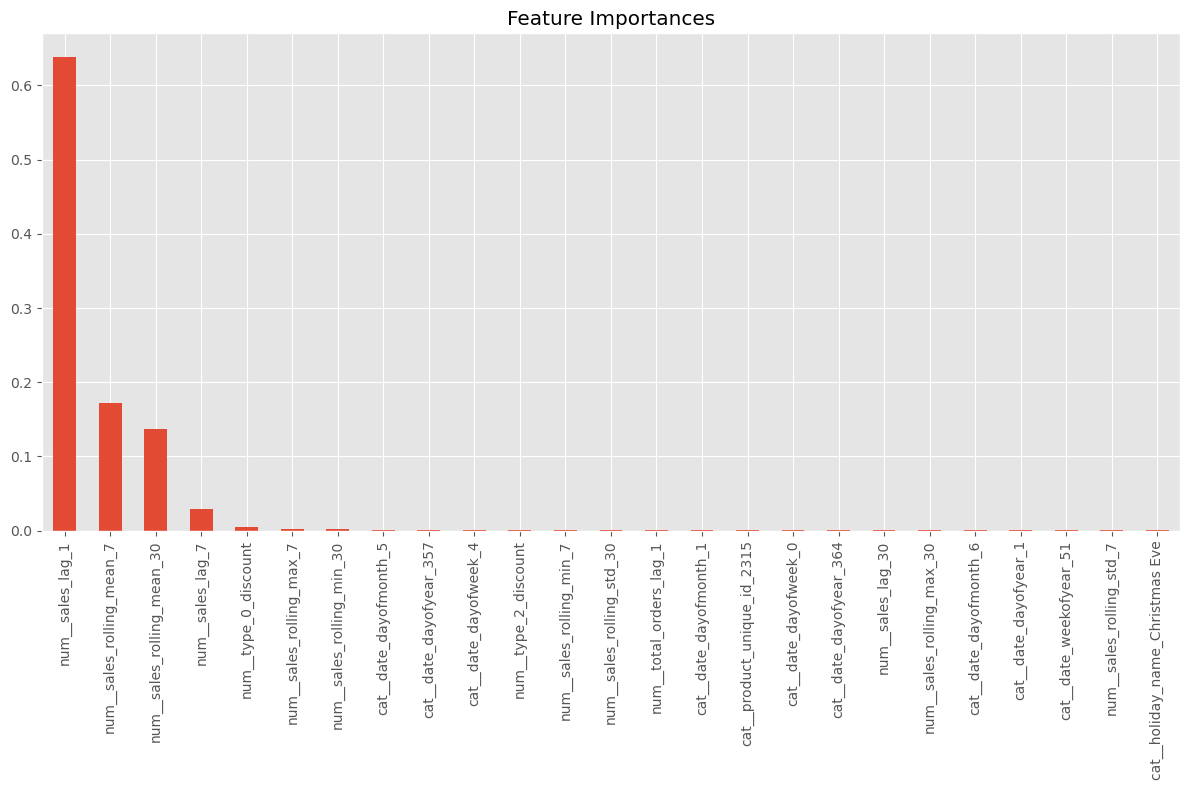

In [85]:
importances = model.named_steps["xgb"].feature_importances_
feature_names = model.named_steps["pre"].get_feature_names_out()

xgb_importances = pd.Series(importances, index=feature_names).sort_values()

print("Feature Importances:")
display(xgb_importances.describe())

fig, ax = plt.subplots()
xgb_importances.nlargest(25).plot.bar(ax=ax)
ax.set_title("Feature Importances")
fig.tight_layout()

### 3.4.2. Reduced Model: Original Scale

This is an attempt to run a model only using features with non-0 importance in the full feature model.

However, this model yields significantly worse results than both the full-feature model and even naive predictors like lag 1.

Therefore, in the next section, we'll move forward with the full features but apply additional scaling for some variables to reduce possible bias and improve performance.

In [103]:
# Select Features with Positive Importance
positive_importance = xgb_importances[xgb_importances > 0.0].reset_index().rename(columns=
                                                                                  {"index":"feature","0":"importance"})
positive_importance[[ "feature_type", "raw_feature"]] = positive_importance["feature"].str.split("__",expand=True)

def get_raw_feature(x):
    for i in features:
        if x.startswith(i):
            return i

positive_importance["original_feature"] = positive_importance["raw_feature"].apply(lambda x: get_raw_feature(x))
positive_importance["original_feature_value"] = positive_importance.apply(lambda row: row["raw_feature"][len(row["original_feature"]):].replace("_",""), axis=1)

positive_importance = positive_importance.groupby(["feature_type","original_feature"])["original_feature_value"].apply(list).reset_index()

num_cols_reduced = positive_importance[positive_importance["feature_type"] == "num"]["original_feature"].to_list()
cat_cols_reduced = positive_importance[positive_importance["feature_type"] == "cat"]["original_feature"].to_list()
cat_cols_reduced_categories = {}

for col in cat_cols_reduced:
    cat_cols_reduced_categories[col] = positive_importance.loc[positive_importance["original_feature"]==col]["original_feature_value"].reset_index(drop=True)[0]

print("Positive Importance Numerical Columns:")
print(num_cols_reduced)
print()
print("Positive Importance Categorical Columns:")
print(cat_cols_reduced)
print()
print("Removed Features:")
print([i for i in num_cols + cat_cols if i not in num_cols_reduced + cat_cols_reduced])


Positive Importance Numerical Columns:
['availability_lag_1', 'date_year', 'sales_lag_1', 'sales_lag_30', 'sales_lag_7', 'sales_rolling_max_30', 'sales_rolling_max_7', 'sales_rolling_mean_30', 'sales_rolling_mean_7', 'sales_rolling_min_30', 'sales_rolling_min_7', 'sales_rolling_std_30', 'sales_rolling_std_7', 'sell_price_main_lag_1', 'total_orders_lag_1', 'type_0_discount', 'type_2_discount', 'type_4_discount', 'type_6_discount']

Positive Importance Categorical Columns:
['L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'date_dayofmonth', 'date_dayofweek', 'date_dayofyear', 'date_is_weekend', 'date_month', 'date_quarter', 'date_weekofyear', 'holiday', 'holiday_name', 'name', 'product_unique_id', 'shops_closed', 'unique_id', 'warehouse', 'winter_school_holidays']

Removed Features:
['type_1_discount', 'type_3_discount', 'type_5_discount', 'warehouse_city', 'school_holidays']


In [105]:
# Fit Model
preprocessor_reduced  = ColumnTransformer([
    ("num", "passthrough", num_cols_reduced),
    ("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_cols_reduced)
], remainder = "drop", verbose_feature_names_out=False).set_output(transform='default')

model_reduced = Pipeline([
    ("selector", preprocessor_reduced),
    ("xgb", GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, max_depth=5, random_state=46))
])

model_reduced.fit(X_train, y_train)

Pipeline(steps=[('selector',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['availability_lag_1',
                                                   'date_year', 'sales_lag_1',
                                                   'sales_lag_30',
                                                   'sales_lag_7',
                                                   'sales_rolling_max_30',
                                                   'sales_rolling_max_7',
                                                   'sales_rolling_mean_30',
                                                   'sales_rolling_mean_7',
                                                   'sales_rolling_min_30',
                                                   'sales_rolling_min_7',
                                                   'sales_rolling_std_30',
                                                   'sales_rolling_std_7',
                                                   'sell_pric...
                                                   'date_dayofmonth',
                                                   'date_dayofweek',
                                                   'date_dayofyear',
                                                   'date_is_weekend',
                                                   'date_month', 'date_quarter',
                                                   'date_weekofyear', 'holiday',
                                                   'holiday_name', 'name',
                                                   'product_unique_id',
                                                   'shops_closed', 'unique_id',
                                                   'warehouse',
                                                   'winter_school_holidays'])],
                                   verbose_feature_names_out=False)),
                ('xgb',
                 GradientBoostingRegressor(learning_rate=0.01, max_depth=5,
                                           random_state=46))])

In [106]:
# Predict and evaluate
y_train_pred_reduced = model_reduced.predict(X_train)
rmse_train = root_mean_squared_error(y_train, y_train_pred_reduced)

y_test_pred_reduced = model_reduced.predict(X_test)
rmse_test = root_mean_squared_error(y_test, y_test_pred_reduced)

performance_df_reduced = pd.DataFrame(data={
    "Set": ["Train Reduced", "Train Reduced", "Train Reduced", "Test Reduced", "Test Reduced", "Test Reduced"],
    "Estimator": ["GradientBoosting", "Target Lag 1", "7-day Rolling Average", "GradientBoosting", "Target Lag 1", "7-day Rolling Average"],
    "RMSE": [rmse_train, root_mean_squared_error(y_train, df_train["sales_lag_1"].fillna(0)), root_mean_squared_error(y_train, df_train["sales_rolling_mean_7"]),
             rmse_test, root_mean_squared_error(y_test, df_test["sales_lag_1"]), root_mean_squared_error(y_test, df_test["sales_rolling_mean_7"])]
})

performance_df_reduced

/opt/miniconda3/envs/myenv_practice/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [13, 14, 16] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Set,Estimator,RMSE
0,Train Reduced,GradientBoosting,150.493
1,Train Reduced,Target Lag 1,91.167
2,Train Reduced,7-day Rolling Average,92.087
3,Test Reduced,GradientBoosting,172.635
4,Test Reduced,Target Lag 1,98.627
5,Test Reduced,7-day Rolling Average,101.164


### 3.4.2. Full-Feature Model: Log Transformed Scale
#### Transform Sales


In [108]:
df_enriched_log1p = df_enriched.copy(deep=True)
feature_to_skew = ["sales", "sales_lag_1"]
for col in feature_to_skew :
    skewness = skew(df_enriched[col].dropna())
    print(f"Skewness of {col}: {skewness:.2f}")
    if abs(skewness) > 1:  # If large skew, apply log transformation
        df_enriched_log1p[f"{col}_log"] = np.log1p(df_enriched[col].clip(lower=0))  # Avoid Negative Values
        df_enriched_log1p.drop(columns = [col], inplace = True) # Drop Original Column
        skewness_log1p = skew(df_enriched_log1p[f"{col}_log"].dropna())
    print(f"Skewness of Log-Transformed {col}: {skewness_log1p:.2f}")
    print()

Skewness of sales: 22.17
Skewness of Log-Transformed sales: 0.15

Skewness of sales_lag_1: 22.17
Skewness of Log-Transformed sales_lag_1: 0.15



In [109]:
# Define features and target
features_to_exclude = ["date","sales_log","total_orders", "sell_price_main", "availability"]
features = [i for i in df_enriched_log1p.columns.to_list() if i not in features_to_exclude]
target_log = "sales_log"

print("Feature:", features)
print("Target:", target_log)
num_cols_log = [col for col in features if col not in cat_cols]

# Change Datatype for Categorical Columns for Easier Processing
df_enriched_log1p[cat_cols] = df_enriched_log1p[cat_cols].astype(dtype="object")

Feature: ['unique_id', 'warehouse', 'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount', 'product_unique_id', 'name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en', 'holiday_name', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'date_year', 'date_month', 'date_dayofmonth', 'date_quarter', 'date_weekofyear', 'date_dayofyear', 'date_dayofweek', 'date_is_weekend', 'warehouse_city', 'total_orders_lag_1', 'sell_price_main_lag_1', 'availability_lag_1', 'sales_lag_7', 'sales_rolling_mean_7', 'sales_rolling_max_7', 'sales_rolling_min_7', 'sales_rolling_std_7', 'sales_lag_30', 'sales_rolling_mean_30', 'sales_rolling_max_30', 'sales_rolling_min_30', 'sales_rolling_std_30', 'sales_lag_1_log']
Target: sales_log


In [110]:
df_train_log = df_enriched_log1p[(df_enriched["date"] >= "2021-01-01") & (df_enriched_log1p["date"] < "2024-01-01")]
df_test_log = df_enriched_log1p[df_enriched_log1p["date"] >= "2024-01-01"]

X_train_log = df_train_log[features]
y_train_log = df_train_log[target_log]

X_test_log = df_test_log[features]
y_test_log = df_test_log[target_log]

In [111]:
preprocessor_log  = ColumnTransformer([
    ("num", "passthrough", num_cols_log),
    ("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_cols)
], remainder = "drop", verbose_feature_names_out=False).set_output(transform='default')

model_log = Pipeline([
    ("pre", preprocessor_log),
    ("xgb", GradientBoostingRegressor(n_estimators=300, learning_rate=0.01, max_depth=3, random_state=208))
])

model_log.fit(X_train_log, y_train_log)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num', 'passthrough',
                                                  ['type_0_discount',
                                                   'type_1_discount',
                                                   'type_2_discount',
                                                   'type_3_discount',
                                                   'type_4_discount',
                                                   'type_5_discount',
                                                   'type_6_discount',
                                                   'date_year',
                                                   'total_orders_lag_1',
                                                   'sell_price_main_lag_1',
                                                   'availability_lag_1',
                                                   'sales_lag_7',
                                                   'sales_rolling_mean_7',
                                                   'sales_rolling_max_7',
                                                   'sales_rol...
                                                   'L3_category_name_en',
                                                   'L4_category_name_en',
                                                   'holiday', 'shops_closed',
                                                   'winter_school_holidays',
                                                   'school_holidays',
                                                   'date_is_weekend',
                                                   'holiday_name', 'date_month',
                                                   'date_dayofmonth',
                                                   'date_quarter',
                                                   'date_weekofyear',
                                                   'date_dayofyear',
                                                   'date_dayofweek'])],
                                   verbose_feature_names_out=False)),
                ('xgb',
                 GradientBoostingRegressor(learning_rate=0.01, n_estimators=300,
                                           random_state=208))])

#### Predict & Evaluate

In [114]:
# Predict and evaluate - Logs
y_train_pred_log = model_log.predict(X_train_log)
rmse_train = root_mean_squared_error(y_train_log, y_train_pred_log)

y_test_pred_log = model_log.predict(X_test_log)
rmse_test = root_mean_squared_error(y_test_log, y_test_pred_log)

performance_df_log = pd.DataFrame(data={
    "Set": ["Train Log Log", "Train", "Test Log", "Test Log"],
    "Estimator": ["GradientBoosting", "Target Lag 1", 
                  "GradientBoosting", "Target Lag 1"],
    "RMSE": [rmse_train, root_mean_squared_error(y_train_log, df_train_log["sales_lag_1_log"].fillna(0)),
             rmse_test, root_mean_squared_error(y_test_log, df_test_log["sales_lag_1_log"].fillna(0)) ] 
             } 
)

performance_df_log

/opt/miniconda3/envs/myenv_practice/lib/python3.12/site-packages/sklearn/preprocessing/_encoders.py:246: UserWarning: Found unknown categories in columns [0, 3, 4] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


,Set,Estimator,RMSE
0,Train Log Log,GradientBoosting,0.462
1,Train,Target Lag 1,0.581
2,Test Log,GradientBoosting,0.438
3,Test Log,Target Lag 1,0.561


In [115]:
# Predict and evaluate - Original Scale

performance_df_exp = pd.DataFrame(data={
    "Set": ["Train OG Scale", "Train OG Scale",
             "Test OG Scale", "Test OG Scale"],
    "Estimator": ["GradientBoosting", "Target Lag 1",
                   "GradientBoosting", "Target Lag 1"
                   ],
    "RMSE": [
                root_mean_squared_error(y_train, np.expm1(y_train_pred_log)), root_mean_squared_error(y_train, df_train["sales_lag_1"].fillna(0)),
                root_mean_squared_error(y_test, np.expm1(y_test_pred_log)), root_mean_squared_error(y_test, df_test["sales_lag_1"].fillna(0) )
             ]
})

performance_df_exp

,Set,Estimator,RMSE
0,Train OG Scale,GradientBoosting,223.243
1,Train OG Scale,Target Lag 1,91.167
2,Test OG Scale,GradientBoosting,271.480
3,Test OG Scale,Target Lag 1,98.627


## 3.6. Gradient Boosting Model using skforecast
### Build Model

In [44]:
# Define features and target
features_to_exclude = ["date", "unique_id","sales",
                       "total_orders", "sell_price_main", "availability", "total_orders_lag_1", "sell_price_main_lag_1", "availability_lag_1",
                       'warehouse', 'warehouse_city',
                        'product_unique_id', 'name', 'L1_category_name_en', 'L2_category_name_en', 'L3_category_name_en', 'L4_category_name_en'] + \
                        df_enriched.columns[df_enriched.columns.str.startswith("sales_")].to_list()
features = [i for i in df_enriched.columns.to_list() if i not in features_to_exclude]
target = "sales"

cat_cols = ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'date_is_weekend',
            'holiday_name', 'date_month', 'date_dayofmonth', 'date_quarter', 'date_weekofyear', 'date_dayofyear', 'date_dayofweek']
num_cols = [col for col in features if col not in cat_cols]

exog_cols = cat_cols + num_cols

# Change Datatype for Categorical Columns for Easier Processing
df_enriched[cat_cols] = df_enriched[cat_cols].astype(dtype="object")

print("Target:", target)
print("Series ID: unique_id")
print("Numerical Columns:", num_cols)
print("Categorical Columns:", cat_cols)

Target: sales
Series ID: unique_id
Numerical Columns: ['type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount', 'date_year']
Categorical Columns: ['holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'date_is_weekend', 'holiday_name', 'date_month', 'date_dayofmonth', 'date_quarter', 'date_weekofyear', 'date_dayofyear', 'date_dayofweek']


In [45]:
# Split Data into Series (Target) and Exogenous Variables
series = df_enriched[["unique_id", "date", "sales"]].copy(deep=True)
series["unique_id"] = series["unique_id"].apply(lambda x: f"unique_id_{x}")

exog = df_enriched[["unique_id","date"] + exog_cols].copy(deep=True)
exog["unique_id"] = exog["unique_id"].apply(lambda x: f"unique_id_{x}")

print("Series:", series.shape)
print(series.columns.to_list())
print("Exog:", exog.shape)
print(exog.columns.to_list())

Series: (3847908, 3)
['unique_id', 'date', 'sales']
Exog: (3847908, 22)
['unique_id', 'date', 'holiday', 'shops_closed', 'winter_school_holidays', 'school_holidays', 'date_is_weekend', 'holiday_name', 'date_month', 'date_dayofmonth', 'date_quarter', 'date_weekofyear', 'date_dayofyear', 'date_dayofweek', 'type_0_discount', 'type_1_discount', 'type_2_discount', 'type_3_discount', 'type_4_discount', 'type_5_discount', 'type_6_discount', 'date_year']


In [ ]:
# Convert Series and Exog data into Dict format to apply skforecast model
series_dict = series_long_to_dict(
    data      = series,
    series_id = 'unique_id',
    index     = 'date',
    values    = 'sales',
    freq      = 'D',

)
exog_dict = exog_long_to_dict(
    data      = exog,
    series_id = 'unique_id',
    index     = 'date',
    freq      = 'D'
)

In [47]:
# Split into Training & Test Set
end_train = '2024-01-01'
series_dict_train = {k: v.loc[: dt.datetime.strptime(end_train, "%Y-%m-%d") - dt.timedelta(days=1),] for k, v in series_dict.items()}
exog_dict_train   = {k: v.loc[: dt.datetime.strptime(end_train, "%Y-%m-%d") - dt.timedelta(days=1),] for k, v in exog_dict.items()}

series_dict_test  = {k: v.loc[end_train:,] for k, v in series_dict.items()}
exog_dict_test    = {k: v.loc[end_train:,] for k, v in exog_dict.items()}

In [48]:
def trygetdate(series_dict, key, idx):
    try:
        return series_dict[key].dropna().index[idx]
    except:
        return np.nan

df_series_train_test_len = pd.DataFrame(data={"unique_id":series_dict.keys()})

df_series_train_test_len["train_length"] = df_series_train_test_len["unique_id"].apply(lambda x: len(series_dict_train[x]))
df_series_train_test_len["train_length_dropna"] = df_series_train_test_len["unique_id"].apply(lambda x: len(series_dict_train[x].dropna()))
df_series_train_test_len["train_start_date"] = df_series_train_test_len["unique_id"].apply(lambda x: trygetdate(series_dict_train, x, 0))
df_series_train_test_len["train_end_date"] = df_series_train_test_len["unique_id"].apply(lambda x: trygetdate(series_dict_train, x, -1))

df_series_train_test_len["test_length"] = df_series_train_test_len["unique_id"].apply(lambda x: len(series_dict_test[x]))
df_series_train_test_len["test_length_dropna"] = df_series_train_test_len["unique_id"].apply(lambda x: len(series_dict_test[x].dropna()))
df_series_train_test_len["test_start_date"] = df_series_train_test_len["unique_id"].apply(lambda x: trygetdate(series_dict_test, x, 0))
df_series_train_test_len["test_end_date"] = df_series_train_test_len["unique_id"].apply(lambda x: trygetdate(series_dict_test, x, -1))

df_series_train_test_len.head()

,unique_id,train_length,train_length_dropna,train_start_date,train_end_date,test_length,test_length_dropna,test_start_date,test_end_date
0,unique_id_0,5,5,2023-07-24,2023-07-28,0,0,NaT,NaT
1,unique_id_1,537,90,2022-07-13,2023-08-16,154,69,2024-03-22,2024-06-02
2,unique_id_10,1217,1197,2020-09-01,2023-12-31,154,154,2024-01-01,2024-06-02
3,unique_id_100,1218,1211,2020-08-31,2023-12-31,154,154,2024-01-01,2024-06-02
4,unique_id_1001,446,420,2022-10-12,2023-12-30,154,148,2024-01-04,2024-06-02


In [49]:
gc.collect()
series_train_over_1000 = df_series_train_test_len[(df_series_train_test_len["train_length_dropna"] > 1000) &  (df_series_train_test_len["test_length_dropna"] > 100)
                          & ( (df_series_train_test_len["test_start_date"] - df_series_train_test_len["train_end_date"]).dt.days == 1.0 )]
print("All Items:", df_series_train_test_len.shape[0])
print("Items with over 1000 observations in Training Set:", series_train_over_1000.shape[0])
series_train_over_1000.describe(percentiles=[]).loc[["count","min","max","mean"],]

All Items: 5180
Items with over 1000 observations in Training Set: 1264


,train_length,train_length_dropna,train_start_date,train_end_date,test_length,test_length_dropna,test_start_date,test_end_date
count,1264.000000,1264.000000,1264,1264,1264.000000,1264.000000,1264,1264
min,1010.000000,1001.000000,2020-08-31 00:00:00,2023-12-31 00:00:00,115.000000,102.000000,2024-01-01 00:00:00,2024-04-24 00:00:00
max,1218.000000,1218.000000,2021-03-27 00:00:00,2023-12-31 00:00:00,154.000000,154.000000,2024-01-01 00:00:00,2024-06-02 00:00:00
mean,1208.905854,1171.796677,2020-09-09 02:15:34.177215232,2023-12-31 00:00:00,153.692247,150.554589,2024-01-01 00:00:00,2024-06-01 16:36:50.126582272


In [50]:
def fit_forecaster(series, exog):
    regressor = XGBRegressor(n_estimators = 200, max_depth=5, random_state=42)
    
    window_features = RollingFeatures(stats=['mean', 'max', 'min', 'mean', 'max', 'min'], window_sizes=[7, 7, 7, 28, 28, 28])

    preprocessor_exog  = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("cat", OneHotEncoder(drop="if_binary", handle_unknown="ignore"), cat_cols)
    ], remainder = "drop")
    
    # Main Forecaster
    forecaster = ForecasterRecursiveMultiSeries(
                        regressor          = regressor, 
                        lags               = 28, 
                        transformer_exog   = preprocessor_exog,
                        transformer_series = FunctionTransformer(func=np.log1p, inverse_func=np.expm1, check_inverse=False),
                        window_features    = window_features,
                        dropna_from_series = True
                    )

    forecaster.fit(series= series, 
                exog= exog, 
                suppress_warnings=True)
    return forecaster

# Fit forecaster
models_dict = []

for idx in np.arange(0, series_train_over_1000.shape[0], step = 250):
    start_idx = idx
    end_idx = idx + 250 if (idx + 250 < series_train_over_1000.shape[0]) else series_train_over_1000.shape[0]
    unique_ids =  [k for k in series_train_over_1000["unique_id"].to_list()[start_idx:end_idx]]
    forecaster = fit_forecaster(series= {k: series_dict_train[k] for k in unique_ids},
                                exog= {k: exog_dict_train[k] for k in unique_ids}
                                )
    models_dict.append({
        "unique_ids": unique_ids,
        "forecaster": forecaster
    })

gc.collect()

42455

### Predict & Evaluate
**RMSE**: XGBoost performs noticeably better than baseline model on average.

**MAPE**: XGBoost performs better than baseline model up to median However, XGBoost MAPE is very skewed likely due to 0.0 values.

**Sample Products**:
- Model captures fluctuations well for some products i.e. 1670.
- For some products i.e. 139,3223… fluctuations are generally captured but large deviations are not captured well.
- For others i.e. 4630 neither fluctuations or scales are well modeled.


In [53]:
predictions_df_test = pd.DataFrame(columns=["date","level","pred","actual"])

performance_df_forecaster = pd.DataFrame(columns=["level","RMSE XGBoost","MAPE XGBoost", "RMSE Last Observed Value", "MAPE Last Observed Value"])

for mdl in models_dict:
    predictions = mdl["forecaster"].predict(steps= 100, 
                                exog={unique_id: exog_dict_test[unique_id] for unique_id in mdl["unique_ids"]}, 
                                suppress_warnings=True).reset_index(names = "date")
    for unique_id in mdl["unique_ids"]:
        pred = predictions[predictions["level"] == unique_id][["date","pred"]]
        actual = series_dict_test[unique_id].loc[:predictions[predictions["level"] == unique_id]["date"].max()].fillna(0).rename("actual")
        
        if len(pred) == 0:
            continue
        else:
            pred_merged_temp = pred.merge(
                        actual,
                        left_on = "date",
                        right_index = True, how = "left").fillna(0)
            pred_merged_temp["level"] = np.repeat(unique_id, len(pred_merged_temp))

            if len(predictions_df_test) == 0:
                predictions_df_test = pred_merged_temp
            else:
                predictions_df_test = pd.concat([
                    predictions_df_test,
                    pred_merged_temp]
                    )

            pred_baseline = np.repeat(series_dict_train["unique_id_0"].tail(1), 100)
            # Evaluate
            performance_temp = pd.DataFrame(data={"level": [unique_id],
                                    "RMSE XGBoost": [root_mean_squared_error(pred_merged_temp["actual"], pred["pred"])],
                                    "MAPE XGBoost": [mean_absolute_percentage_error(pred_merged_temp["actual"], pred["pred"])],
                                    "RMSE Last Observed Value": [root_mean_squared_error(pred_merged_temp["actual"], pred_baseline)],
                                    "MAPE Last Observed Value": [mean_absolute_percentage_error(pred_merged_temp["actual"], pred_baseline)],
                                    })
            
            if len(performance_df_forecaster) == 0:
                performance_df_forecaster = performance_temp.copy()
            else:
                performance_df_forecaster = pd.concat(
                    [performance_df_forecaster,
                    performance_temp]
                )
            
            del pred_merged_temp
            del performance_temp
            gc.collect()

print("Number of Predictable Unique IDs:", performance_df_forecaster.shape[0])
print("Summary of Metrics on Test Set:")
performance_df_forecaster.describe()

Number of Predictable Unique IDs: 1264
Summary of Metrics on Test Set:


,RMSE XGBoost,MAPE XGBoost,RMSE Last Observed Value,MAPE Last Observed Value
count,1264.000000,1.264000e+03,1264.000000,1.264000e+03
mean,97.935323,4.389932e+16,153.526781,6.916663e+15
std,217.015872,1.514766e+17,611.565700,1.442857e+16
min,3.529961,8.301938e-02,11.750359,1.504355e-01
25%,15.910723,3.079449e-01,34.670192,8.048898e-01
50%,36.806917,1.145183e+00,49.423118,7.455724e+00
75%,97.893474,2.709724e+16,88.553130,6.008703e+15
max,3220.815881,2.304057e+18,15537.831072,1.111610e+17


In [69]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
performance_df_forecaster.describe(percentiles=[0.25 , 0.5, 0.6, 0.75])

,RMSE XGBoost,MAPE XGBoost,RMSE Last Observed Value,MAPE Last Observed Value
count,1264.000,1264.000,1264.000,1264.000
mean,97.935,43899323034943456.000,153.527,6916663224864618.000
std,217.016,151476616962654496.000,611.566,14428573975009736.000
min,3.530,0.083,11.750,0.150
25%,15.911,0.308,34.670,0.805
50%,36.807,1.145,49.423,7.456
60%,52.644,5486188412298353.000,54.204,3004351311418858.000
75%,97.893,27097243040786640.000,88.553,6008702622837720.000
max,3220.816,2304056868527213824.000,15537.831,111160998522497728.000


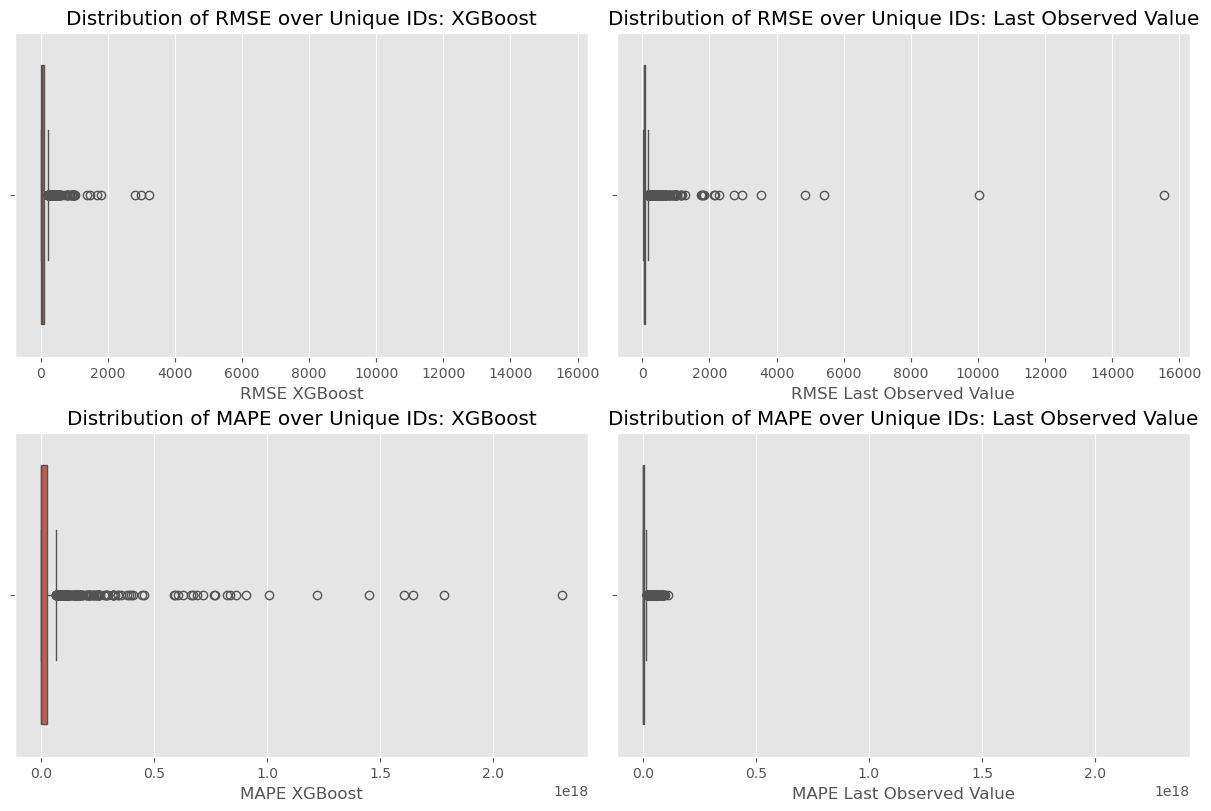

In [58]:
fig, axes = plt.subplots(nrows=2, ncols=2, constrained_layout = True)
axes = axes.ravel()
sns.boxplot(performance_df_forecaster, x = "RMSE XGBoost",
             ax = axes[0])
axes[0].set_title("Distribution of RMSE over Unique IDs: XGBoost")

sns.boxplot(performance_df_forecaster, x = "RMSE Last Observed Value",
             ax = axes[1])
axes[1].set_title("Distribution of RMSE over Unique IDs: Last Observed Value")

axes[0].sharex(axes[1])

sns.boxplot(performance_df_forecaster, x = "MAPE XGBoost",
              ax = axes[2])
axes[2].set_title("Distribution of MAPE over Unique IDs: XGBoost")

sns.boxplot(performance_df_forecaster, x = "MAPE Last Observed Value",
              ax = axes[3])
axes[3].set_title("Distribution of MAPE over Unique IDs: Last Observed Value")

axes[3].sharex(axes[2])

plt.show()


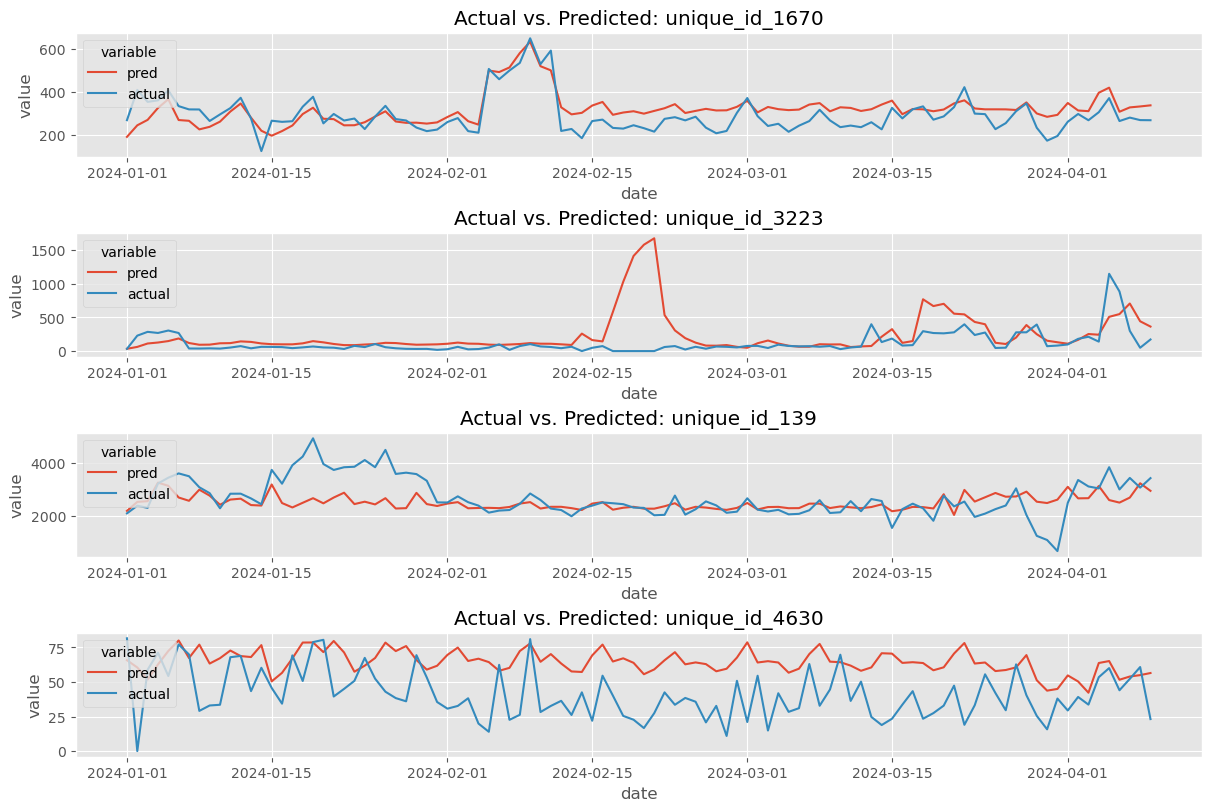

In [68]:
# Plot Predictions for Sample SKU
predictions_df_test_melted = predictions_df_test.melt(id_vars=["date","level"])
unique_id_sample = predictions_df_test_melted["level"].sample(4, random_state=5231).to_list()

fig, axes = plt.subplots(nrows=4, constrained_layout = True)
for i in range(len(unique_id_sample)):
    sns.lineplot( predictions_df_test_melted[predictions_df_test_melted["level"] == unique_id_sample[i]], x = "date", y = "value", hue="variable",
                ax = axes[i]  )
    sns.move_legend(axes[i], "upper left")
    axes[i].set_title(f"Actual vs. Predicted: {unique_id_sample[i]}")
plt.show()

# References:

**Time Series Feature Encoding**
- [Cyclical Encoding](https://towardsdatascience.com/cyclical-encoding-an-alternative-to-one-hot-encoding-for-time-series-features-4db46248ebba/)
- [Cyclical features in time series - Skforecast Docs](https://skforecast.org/0.15.0/faq/cyclical-features-time-series.html)
- [Feature Engineering for Time-Series Data: Methods and Applications](https://www.geeksforgeeks.org/feature-engineering-for-time-series-data-methods-and-applications/ 
)

**Seasonality**
- [Seasonality Detection](https://www.geeksforgeeks.org/seasonality-detection-in-time-series-data/)
- [Seasonal Decompose Intepretation](https://stats.stackexchange.com/questions/592681/seasonal-decompose-interpretation)
- [Time Series Intepreting ACF and PACF](https://www.kaggle.com/code/iamleonie/time-series-interpreting-acf-and-pacf)

**Modelling**
- [Time Series Forecasting using XGBoost](https://www.kaggle.com/code/youknowjp/time-series-forcasting-using-xgboost)
- [[Tutorial] Time Series forecasting with XGBoost](https://www.kaggle.com/code/robikscube/tutorial-time-series-forecasting-with-xgboost)
- [Global Forecasting Models: Independent multi-series forecasting](https://skforecast.org/0.16.0/user_guides/independent-multi-time-series-forecasting#exogenous-variables-in-multi-series-forecasting)

**Feature Importance**
- [Feature importances with a forest of trees](https://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html)

**Feature Selection**
- [SelectFromModel](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)
- [Feature Selection with XGBoost](https://machinelearningmastery.com/feature-importance-and-feature-selection-with-xgboost-in-python/)